In [1]:
#@title Click Headers
from IPython.display import HTML,display
import random
def clickh(string,emo='✒️'):
    font_color_set=['#E91E63','#FA7A00','#FED85D','#91E351',
                    '#00D8A0','#1AADE0','#3355FF','#7855EE']
    font_family_set=['times','courier']
    font_size_set=list(range(20,28,1))
    html_str="""
    <p class='click_header' 
    onclick='setStyle(this,
        &#34;"""+random.choice(font_color_set)+"""&#34;,
        &#34;"""+random.choice(font_family_set)+"""&#34;,
        &#34;"""+str(random.choice(font_size_set))+"""&#34;)'
    style='text-shadow:3px 3px 3px #ccc; font-family:courier; 
    font-size:20px; color:#ff33ff;'>
    """+emo+"""  """+string+"""
    </p>
    <script>
    function setStyle(element,color,family,size) {
     var docs=document.getElementsByClassName('click_header');
     for (var i=0; i<docs.length; i++) {
         docs[i].style='text-shadow:3px 3px 3px slategray; '+
                       'font-family:'+family+
                       '; font-size:'+size+'px; '; 
         docs[i].style.color=color;}; };
    </"""+"""script>"""
    display(HTML(html_str))

In [2]:
clickh('Code Modules & Parameters')

In [3]:
import os,numpy as np,pandas as pd,pylab as pl
import h5py,urllib,torch,torchvision,tensorflow as tf
from torch.utils.data import Dataset as tds,DataLoader as tdl
import torch.nn.functional as tnnf,torch.nn as tnn
from IPython.core.magic import register_line_magic
from IPython.display import HTML,display
dev=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
clickh('Data')

In [5]:
names=[['lowercase','uppercase'],
       [s for s in u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'],
       ['single-colored paper','striped paper','squared paper','graph paper']]
path='https://raw.githubusercontent.com/OlgaBelitskaya/data/main/zip_letters/'
def file_name(lower_upper,letter,background,names=names):
    file_pre='%02d_'%names[0].index(lower_upper)
    file_pre+='%02d_'%names[1].index(letter)
    file_pre+='%02d'%names[2].index(background)
    return file_pre+'.h5'
file_names=[file_name(n0,n1,n2) for n2 in names[2] 
            for n1 in names[1] for n0 in names[0]]
file_names=[file_names[2*i] for i in range(9)]; file_names

['00_00_00.h5',
 '00_01_00.h5',
 '00_02_00.h5',
 '00_03_00.h5',
 '00_04_00.h5',
 '00_05_00.h5',
 '00_06_00.h5',
 '00_07_00.h5',
 '00_08_00.h5']

In [6]:
images,nlabels,labels=[],[],[]
for h5f in file_names:
    input_file=urllib.request.urlopen(path+h5f)
    output_file=open(h5f,'wb'); output_file.write(input_file.read())
    output_file.close(); input_file.close()
    with h5py.File(h5f,'r') as f:
        keys=list(f.keys()); nums=f[keys[0]].shape[0]
        print('file name: %s; '%h5f+'number of images: %d'%nums)
        images.append(np.array(f[keys[0]],dtype='float32'))
        nlabels=[el.decode('utf-8') for el in f[keys[1]]]
        labels.append(np.array(
            nums*[[names[i].index(nlabels[i]) 
                   for i in range(3)]],dtype='int32'))
        f.close(); os.remove(h5f)
images=np.concatenate(images,axis=0)
labels=np.concatenate(labels,axis=0)
images.shape,images.dtype,nlabels,labels.shape,labels.dtype

file name: 00_00_00.h5; number of images: 635
file name: 00_01_00.h5; number of images: 631
file name: 00_02_00.h5; number of images: 928
file name: 00_03_00.h5; number of images: 1006
file name: 00_04_00.h5; number of images: 907
file name: 00_05_00.h5; number of images: 1202
file name: 00_06_00.h5; number of images: 1013
file name: 00_07_00.h5; number of images: 887
file name: 00_08_00.h5; number of images: 948


((8157, 32, 32, 3),
 dtype('float32'),
 ['lowercase', 'з', 'single-colored paper'],
 (8157, 3),
 dtype('int32'))

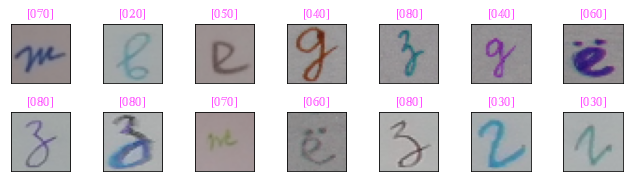

In [7]:
shuffle_ids=np.arange(images.shape[0])
np.random.RandomState(1234).shuffle(shuffle_ids)
images=images[shuffle_ids]
labels=labels[shuffle_ids]
def display_images(n_images,cols,images,labels):
    rows=n_images//cols    
    pl.figure(figsize=(1.3*cols,1.3*rows))
    for i in range(n_images):
        pl.subplot(rows,cols,i+1); pl.imshow(images[i])
        pl.title('$\\mathbb{'+str(labels[i])+'}$',color='#ff36ff')
        pl.xticks([]); pl.yticks([])
    pl.tight_layout(); pl.show()
display_images(14,7,images,labels)

In [8]:
img_size=28; N=labels.shape[0]; n=int(.2*N)
images=tf.image.resize(images,[img_size,img_size])
images=x=(np.dot(images.numpy(),[.299,.587,.114]))\
.reshape(-1,1,img_size,img_size)
x_test,x_train=images[:n],images[n:]
y_test,y_train=labels[:,1][:n],labels[:,1][n:]

(1, 28, 28) 0.590327716247335


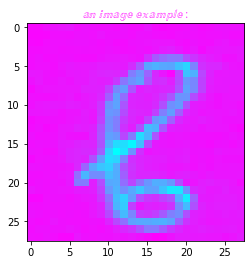

In [9]:
pl.imshow(x_test[1].reshape(img_size,img_size),cmap=pl.cm.cool)
pl.title('$\\mathbb{'+'an \\; image \\; example:'+'}$',color='#ff36ff')
print(x_test[1].shape,x_test.mean())

In [10]:
random_seed=23; batch_size=128
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]
train=TData(x_train,y_train); test=TData(x_test,y_test)
train_loader=tdl(dataset=train,shuffle=True,batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False,batch_size=batch_size)

image dimensions: torch.Size([128, 1, 28, 28])
label dimensions: torch.Size([128])


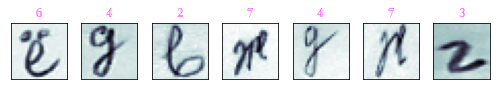

In [11]:
@register_line_magic
def display_examples(n):
    if n=='1': data_loader=train_loader
    if n=='2': data_loader=test_loader
    for images,labels in data_loader:  
        print('image dimensions: %s'%str(images.shape))
        print('label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(7,2))
        for i in range(n,n+7):
            ax=fig.add_subplot(1,7,i-n+1,xticks=[],yticks=[])
            ax.set_title(
                '$\\mathbb{'+str(labels[i].item())+'}$',color='#ff36ff')
            ax.imshow(
                (images[i]).reshape(img_size,img_size),cmap=pl.cm.bone)
        pl.tight_layout(); pl.show(); break
%display_examples 2

In [12]:
clickh('Pytorch Autoencoders')

In [13]:
ch1,ch2,ch3=16,48,144
def to_onehot(labels,num_classes,device):
    labels_ohe=torch.zeros(labels.size()[0],num_classes).to(device)
    labels_ohe.scatter_(1,labels.view(-1,1),1)
    return labels_ohe
class CondVarAE(tnn.Module):
    def __init__(self,num_features,num_latent,num_classes):
        super(CondVarAE,self).__init__()
        self.num_classes=num_classes
        # ENCODER
        self.conv_en1=tnn.Conv2d(
            in_channels=1+self.num_classes,out_channels=ch1,
            kernel_size=(6,6),stride=(2,2),padding=0)
        self.conv_en2=tnn.Conv2d(
            in_channels=ch1,out_channels=ch2,
            kernel_size=(4,4),stride=(2,2),padding=0)                        
        self.conv_en3=tnn.Conv2d(
            in_channels=ch2,out_channels=ch3,
            kernel_size=(2,2),stride=(2,2),padding=0)                     
        self.z_mean=tnn.Linear(ch3*2*2,num_latent)
        self.z_log_var=tnn.Linear(ch3*2*2,num_latent)
        # DECODER
        self.linear_de1=tnn.Linear(num_latent+self.num_classes,ch3*2*2)
        self.deconv_de1=tnn.ConvTranspose2d(
            in_channels=ch3,out_channels=ch2,
            kernel_size=(2,2),stride=(2,2),padding=0)                             
        self.deconv_de2=tnn.ConvTranspose2d(
            in_channels=ch2,out_channels=ch1,
            kernel_size=(4,4),stride=(3,3),padding=1)       
        self.deconv_de3=tnn.ConvTranspose2d(
            in_channels=ch1,out_channels=1,
            kernel_size=(6,6),stride=(3,3),padding=4)        
    def reparameterize(self, z_mu, z_log_var):
        eps=torch.randn(z_mu.size(0),z_mu.size(1)).to(dev)
        return z_mu+eps*torch.exp(z_log_var/2.)  
    def encoder(self,features,targets):
        onehot_targets=to_onehot(targets,self.num_classes,dev)
        onehot_targets=onehot_targets.view(-1,self.num_classes,1,1)        
        ones=torch.ones(features.size()[0],self.num_classes,
                        features.size()[2],features.size()[3], 
                        dtype=features.dtype).to(dev)
        ones=ones*onehot_targets
        x=torch.cat((features,ones),dim=1)    
        x=self.conv_en1(x); x=tnnf.leaky_relu(x)      
        x=self.conv_en2(x); x=tnnf.leaky_relu(x)
        x=self.conv_en3(x); x=tnnf.leaky_relu(x)     
        z_mean=self.z_mean(x.view(-1,ch3*2*2))
        z_log_var=self.z_log_var(x.view(-1,ch3*2*2))
        encoded=self.reparameterize(z_mean,z_log_var)
        return z_mean,z_log_var,encoded
    def decoder(self,encoded,targets):
        onehot_targets=to_onehot(targets,self.num_classes,dev)
        encoded=torch.cat((encoded,onehot_targets),dim=1)       
        x=self.linear_de1(encoded)
        x=x.view(-1,ch3,2,2) 
        x=self.deconv_de1(x); x=tnnf.leaky_relu(x)      
        x=self.deconv_de2(x); x=tnnf.leaky_relu(x)
        x=self.deconv_de3(x); x=tnnf.leaky_relu(x)
        decoded=torch.sigmoid(x)
        return decoded
    def forward(self,features,targets):      
        z_mean,z_log_var,encoded=self.encoder(features,targets)
        decoded=self.decoder(encoded,targets)     
        return z_mean,z_log_var,encoded,decoded

In [14]:
torch.manual_seed(random_seed)
learning_rate=.001; num_latent=121
num_classes=len(set(y_train))
model=CondVarAE(num_features=img_size**2,
                num_latent=num_latent,num_classes=num_classes)
model=model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [15]:
epochs=300
for epoch in range(epochs):
    for batch_ids,(features,targets) in enumerate(train_loader):
        features=features.to(dev); targets=targets.to(dev)
        z_mean,z_log_var,encoded,decoded=model(features,targets.long())
        kl_divergence=\
        (.5*(z_mean**2+torch.exp(z_log_var)-z_log_var-1)).sum()
        pixelwise_bce=tnnf.binary_cross_entropy(
            decoded,features,reduction='sum')
        cost=kl_divergence+pixelwise_bce
        optimizer.zero_grad()
        cost.backward(); optimizer.step()
        if not batch_ids%100:
            print ('Epoch: %03d/%03d | Batch: %03d/%03d | Cost: %.4f' 
                   %(epoch+1,epochs,batch_ids,len(train_loader),cost))

Epoch: 001/300 | Batch: 000/051 | Cost: 68625.8047
Epoch: 002/300 | Batch: 000/051 | Cost: 67359.6875
Epoch: 003/300 | Batch: 000/051 | Cost: 67417.3359
Epoch: 004/300 | Batch: 000/051 | Cost: 67087.9141
Epoch: 005/300 | Batch: 000/051 | Cost: 67328.6875
Epoch: 006/300 | Batch: 000/051 | Cost: 67182.1484
Epoch: 007/300 | Batch: 000/051 | Cost: 66885.7344
Epoch: 008/300 | Batch: 000/051 | Cost: 67082.0234
Epoch: 009/300 | Batch: 000/051 | Cost: 66951.5859
Epoch: 010/300 | Batch: 000/051 | Cost: 67115.2188
Epoch: 011/300 | Batch: 000/051 | Cost: 67004.9453
Epoch: 012/300 | Batch: 000/051 | Cost: 66914.3438
Epoch: 013/300 | Batch: 000/051 | Cost: 66608.4766
Epoch: 014/300 | Batch: 000/051 | Cost: 66907.7422
Epoch: 015/300 | Batch: 000/051 | Cost: 66905.8672
Epoch: 016/300 | Batch: 000/051 | Cost: 67013.0312
Epoch: 017/300 | Batch: 000/051 | Cost: 66744.6875
Epoch: 018/300 | Batch: 000/051 | Cost: 67138.4609
Epoch: 019/300 | Batch: 000/051 | Cost: 66856.9609
Epoch: 020/300 | Batch: 000/051

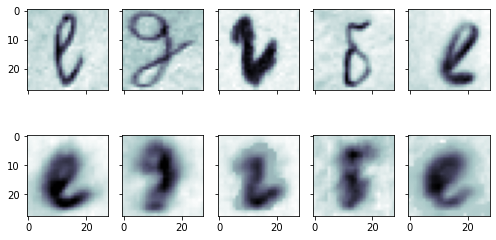

In [16]:
num_images=5
fig,axes=pl.subplots(
    nrows=2,ncols=num_images,
    sharex=True,sharey=True,figsize=(7,4))
original_images=features[:num_images]
decoded_images=decoded[:num_images]
for i in range(num_images):
    for ax,img in zip(axes,[original_images,decoded_images]):
        ax[i].imshow(img[i].detach().to(torch.device('cpu'))\
                     .reshape((img_size,img_size)),cmap='bone')
pl.tight_layout(); pl.show()

In [18]:
@register_line_magic
def display_gen(l):
    l=int(l); num_images=5
    labels=torch.tensor([l]*num_images).to(dev)
    latent_features=torch.randn(num_images,num_latent).to(dev)
    generated_images=model.decoder(latent_features,labels)
    decoded_images=generated_images[:num_images]
    fig,axes=pl.subplots(nrows=1,ncols=num_images,
                         figsize=(7,2),sharey=True)
    for ax,img in zip(axes,decoded_images):
        ax.imshow(img.detach().to(torch.device('cpu'))\
                  .reshape((img_size,img_size)),cmap='bone')
    pl.tight_layout(); pl.show()

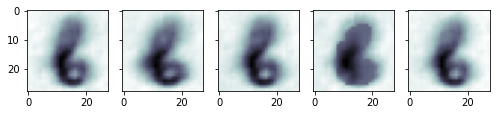

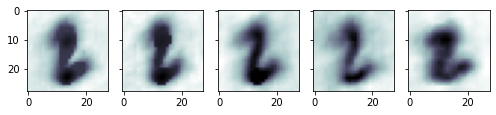

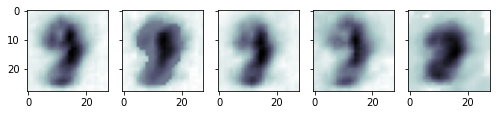

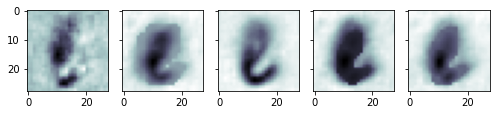

In [19]:
%display_gen 2
%display_gen 3
%display_gen 4
%display_gen 5